In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

import seaborn as sns

def boxplot_df(df):
    x = sns.boxplot(data=df)
    x.set(xticklabels=[])
    x.tick_params(bottom=False)
    x.set(xlabel=None)
    plt.show()
    return

def get_n_class(df, cls, n):
    selected = df.loc[df['class']==cls, :]
    selected = selected.sample(frac=1)
    try:
        return selected.iloc[:n, :]
    except:
        return selected
    

from sklearn.ensemble import GradientBoostingClassifier as GBC
from sklearn import metrics

def get_x(df):
    return df.loc[:, df.columns != 'class']
    
def get_y(df):
    return df.loc[:, ['class']].T.values[0]

def get_probs_positive_class(pred):
        positive_probs = []

        for prediction in pred:
            positive_probs.append(prediction[1])
        return positive_probs
    

def load_dataframes(train_path, test_path):
    train_df = pd.read_csv(train_path, index_col=0)
    test_df = pd.read_csv(test_path, index_col=0)
    return train_df, test_df


def cross_testing_accuracy(train_df, test_df, genes_ranking_path, thresholds, trained_clfs=None):
    gdf = pd.read_csv(genes_ranking_path, index_col=0)
    genes = list(gdf.index)
    test_df = test_df.sample(frac=1)
    for i, threshold in enumerate(thresholds):
        print("Cross-testing with threshold:", threshold)
        ts_top = test_df.loc[:, genes[0:threshold]+['class']]

        if trained_clfs:
            clf = trained_clfs[i]
            
        else:
            clf = GBC()
            tr_top = train_df.loc[:, genes[0:threshold]+['class']]
            X_train = get_x(tr_top)
            y_train = get_y(tr_top)
            clf.fit(X_train, y_train)
        

        X_test = get_x(ts_top)
        y_test = get_y(ts_top)

        acc_score = clf.score(X_test, y_test)

        pred = clf.predict_proba(X_test)
        y_pred = np.argmax(pred, axis=1)
        pred = get_probs_positive_class(pred)

        roc_auc = metrics.roc_auc_score(np.array(y_test, dtype=int), pred)
        pred_accuracy = metrics.accuracy_score(y_test, y_pred)

        print("Accuracy with .score:", acc_score)
        print("Accuracy with .predict_proba:", pred_accuracy)
        print("ROC AUC:", roc_auc)
        print("Predictions:", y_pred)
        print("\n")
        

def get_trained_clfs(train_df, thresholds, genes_ranking_path):
    
    trained_clfs = []
    gdf = pd.read_csv(genes_ranking_path, index_col=0)
    genes = list(gdf.index)
    
    for threshold in thresholds:
        print("Training with threshold:", threshold)
        clf = GBC()
        
        tr_top = train_df.loc[:, genes[0:threshold]+['class']]

        X_train = get_x(tr_top)
        y_train = get_y(tr_top)

        clf.fit(X_train, y_train)
        trained_clfs.append(deepcopy(clf))
    
    return trained_clfs

In [2]:
p_root = "/home/colombelli/Documents/datasets/lung cancer/intersect/"
df0_name = "gse19188.csv"
df1_name = "cumida1.csv"
df2_name = "cumida2.csv"
df3_name = "cumida3.csv"

df0 = pd.read_csv(p_root+df0_name, index_col=0)
df1 = pd.read_csv(p_root+df1_name, index_col=0)
df2 = pd.read_csv(p_root+df2_name, index_col=0)
df3 = pd.read_csv(p_root+df3_name, index_col=0)


20 random samples each dataset:


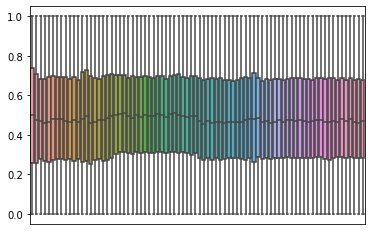


20 random NORMAL samples each dataset:


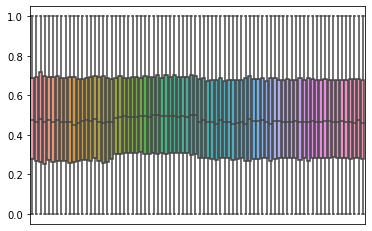


20 random TUMOR samples each dataset:


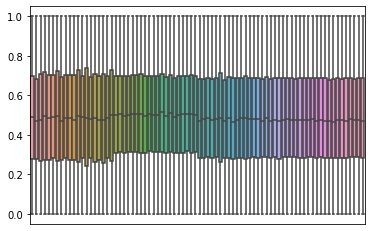

In [3]:
dfs = [df0,df1,df2,df3]

#ALL SAMPLES
dfs20 = []
for df in dfs:
    df = df.sample(frac=1)
    dfs20.append(df.iloc[0:20, 0:-1])

dfConc = pd.concat([dfs20[0], dfs20[1], dfs20[2], dfs20[3]]).T
print("\n20 random samples each dataset:")
boxplot_df(dfConc)


#NORMAL SAMPLES
dfs20 = []
for df in dfs:
    df = df.sample(frac=1)
    pldf = get_n_class(df, 0, 20)
    dfs20.append(pldf.iloc[:, 0:-1])

dfConc = pd.concat([dfs20[0], dfs20[1], dfs20[2], dfs20[3]]).T
print("\n20 random NORMAL samples each dataset:")
boxplot_df(dfConc)


#TUMOR SAMPLES
dfs20 = []
for df in dfs:
    df = df.sample(frac=1)
    pldf = get_n_class(df, 1, 20)
    dfs20.append(pldf.iloc[:, 0:-1])

dfConc = pd.concat([dfs20[0], dfs20[1], dfs20[2], dfs20[3]]).T
print("\n20 random TUMOR samples each dataset:")
boxplot_df(dfConc)

In [4]:
ths = [1, 5, 10, 15, 20, 50, 100, 200, 300, 400]#, 1000, 5000, -1]
genes_rank = "/home/colombelli/Documents/experiments/rankingCombat2/het_gse19188_E1/selection/agg_ranking_th1.csv"

dfs = [df0, df1, df2, df3]
for df in dfs:
    df = df.sample(frac=1)
    
df_train = pd.concat([df0.loc[df0['class'] == 0], df0.loc[df0['class'] == 1].iloc[0:65, :]]).sample(frac=1)
trained_clfs = get_trained_clfs(df_train, ths, genes_rank)

Training with threshold: 1
Training with threshold: 5
Training with threshold: 10
Training with threshold: 15
Training with threshold: 20
Training with threshold: 50
Training with threshold: 100
Training with threshold: 200
Training with threshold: 300
Training with threshold: 400


In [5]:
cross_testing_accuracy(None, df1, genes_rank, ths, trained_clfs)

Cross-testing with threshold: 1
Accuracy with .score: 0.8444444444444444
Accuracy with .predict_proba: 0.8444444444444444
ROC AUC: 0.9597332015810276
Predictions: [1 0 1 0 0 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 0 1 0 0 1 1 0 0 1 1 1 1
 1 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 1 1 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 1 0 1
 0 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0]


Cross-testing with threshold: 5
Accuracy with .score: 0.9666666666666667
Accuracy with .predict_proba: 0.9666666666666667
ROC AUC: 0.9990118577075099
Predictions: [1 0 1 0 0 1 1 1 0 0 1 1 0 0 1 1 0 1 0 1 1 0 0 1 1 0 0 0 1 1 1 0 0 1 0 1 1
 1 0 0 0 1 1 1 1 0 0 1 0 1 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1
 0 1 0 1 1 0 1 1 0 1 1 1 1 1 0 0]


Cross-testing with threshold: 10
Accuracy with .score: 0.9444444444444444
Accuracy with .predict_proba: 0.9444444444444444
ROC AUC: 0.9955533596837944
Predictions: [1 0 1 0 0 1 1 1 0 0 1 1 0 0 1 1 0 1 1 1 1 0 0 1 0 0 0 0 1 1 1 0 0 1 0 1 1
 1 0 0 0 1 1 1 1 0 0 1 1 1 0 1 0 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 

In [6]:
cross_testing_accuracy(None, df2, genes_rank, ths, trained_clfs)

Cross-testing with threshold: 1
Accuracy with .score: 0.7105263157894737
Accuracy with .predict_proba: 0.7105263157894737
ROC AUC: 0.8302032019704435
Predictions: [0 1 1 0 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 1 0 1 0 0 1 1 0 0 0 0 1 1 0 0
 1 0 0 1 0 0 0 0 1 0 0 0 1 0 1 0 1 1 0 0 1 0 0 0 0 0 0 1 1 1 0 1 0 1 0 0 1
 0 0 1 1 1 0 1 0 1 1 1 1 0 0 1 1 0 1 0 0 0 0 1 1 0 0 1 1 1 0 1 1 0 1 1 0 0
 0 1 0]


Cross-testing with threshold: 5
Accuracy with .score: 0.8508771929824561
Accuracy with .predict_proba: 0.8508771929824561
ROC AUC: 0.9530480295566502
Predictions: [0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 0 1 1 0 1 0 0 1 1 1 1 1 0 1 0 0 0
 1 0 0 0 0 0 0 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 1 0 1
 0 0 1 1 1 0 1 0 1 1 1 1 0 0 0 1 0 0 0 0 1 0 0 1 0 1 1 0 1 0 0 1 1 0 1 0 1
 1 0 0]


Cross-testing with threshold: 10
Accuracy with .score: 0.8771929824561403
Accuracy with .predict_proba: 0.8771929824561403
ROC AUC: 0.9613608374384236
Predictions: [0 0 1 0 0 1 1 0 0 0 0 1 0 1 0 1 1 0 0 0

In [7]:
cross_testing_accuracy(None, df3, genes_rank, ths, trained_clfs)

Cross-testing with threshold: 1
Accuracy with .score: 0.7291666666666666
Accuracy with .predict_proba: 0.7291666666666666
ROC AUC: 0.896701388888889
Predictions: [0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 0 1 0 0 0 0 0 1 0 1 0 0
 0 0 1 0 1 0 1 0 0 1 0]


Cross-testing with threshold: 5
Accuracy with .score: 0.9583333333333334
Accuracy with .predict_proba: 0.9583333333333334
ROC AUC: 0.9947916666666666
Predictions: [1 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 1 1 0 1 1 1
 1 0 1 0 0 0 1 0 0 1 0]


Cross-testing with threshold: 10
Accuracy with .score: 0.875
Accuracy with .predict_proba: 0.875
ROC AUC: 0.9635416666666666
Predictions: [1 1 1 0 0 1 1 0 0 0 0 0 0 1 0 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1
 1 0 1 0 0 0 1 0 0 1 0]


Cross-testing with threshold: 15
Accuracy with .score: 0.9166666666666666
Accuracy with .predict_proba: 0.9166666666666666
ROC AUC: 0.9618055555555556
Predictions: [1 0 1 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 1 0 0 1 1 1 0 1 1 0 0 1